In [ ]:
!pip install pytorch_pretrained_bert
!pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 4.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manyl

In [ ]:
# Import Libraries

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForSequenceClassification
import torch.optim as optim
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from transformers import BertModel, BertTokenizer
import torch

# Load a pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

# Convert tokens to IDs
# Prepare input
tokens = tokenizer.tokenize("[CLS] Hello, how are you? [SEP]")
input_ids = tokenizer.convert_tokens_to_ids(tokens)

# Forward pass through the embeddings layer of BERT
embeddings = model.embeddings(torch.tensor([[input_ids]]))

# 'embeddings' now contains the embedding for the token "hello"
print (embeddings.shape)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

torch.Size([1, 1, 8, 768])


In [ ]:
# Prepare input
tokens = tokenizer.tokenize("[CLS] Hello, how are you? [SEP]")
input_ids = tokenizer.convert_tokens_to_ids(input_ids)

# Convert to tensor and add batch dimension
input_ids_tensor = torch.tensor([input_ids])  # Notice the additional brackets for batch dimension

# Get all hidden states
# outputs = model(input_ids_tensor)
outputs = model(input_ids_tensor)

# # The last hidden state (the output of the last layer for each token)
last_hidden_states = outputs.last_hidden_state

print(last_hidden_states.shape)

torch.Size([1, 8, 768])


In [ ]:
# Download the dataset
!gdown --id 1NdvIddoyYy2idsAWxJ8lodKfD-PZhmyL

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1NdvIddoyYy2idsAWxJ8lodKfD-PZhmyL
To: /content/in_domain_train.tsv
100% 429k/429k [00:00<00:00, 94.3MB/s]


Get the data:
https://nyu-mll.github.io/CoLA/

 The Corpus of Linguistic Acceptability (CoLA) dataset for single sentence classification.

It's a set of sentences labeled as grammatically correct or incorrect. The data is as follows:

Column 1: the code representing the source of the sentence.

Column 2: the acceptability judgment label (0=unacceptable, 1=acceptable).

Column 3: the acceptability judgment as originally notated by the author.

Column 4: the sentence.

In [ ]:
df = pd.read_csv("in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])[['label', 'sentence']]
df.shape

(8551, 2)

In [ ]:
df.sample(10)

,label,sentence
246,1,"The longer he has to wait, the angrier John gets."
4100,0,The general commended that all troops was in d...
5211,0,It's not the case that every boy has any potat...
4844,1,Who do you guess will be here?
6381,1,Almost any pilot could be flying this plane.
7365,0,It mattered with a telescope.
2832,0,The old and new carts banged.
134,1,"Keep your mouth shut tighter, the more John ea..."
5202,1,Every student who handed in any homework will ...
598,0,The kettle bubbled water up.


In [ ]:
# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

In [ ]:
sentences[0]

"[CLS] Our friends won't buy this analysis, let alone the next one we propose. [SEP]"

import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['[CLS]', 'our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


BERT INPUT REQUIREMENTS:
**input ids:** a sequence of integers identifying each input token to its index number in the BERT tokenizer vocabulary
**segment mask:** (optional) a sequence of 1s and 0s used to identify whether the input is one sentence or two sentences long. For one sentence inputs, this is simply a sequence of 0s. For two sentence inputs, there is a 0 for each token of the first sentence, followed by a 1 for each token of the second sentence
**attention mask:** (optional) a sequence of 1s and 0s, with 1s for all input tokens and 0s for all padding tokens (we'll detail this in the next paragraph)
**labels:** a single value of 1 or 0. In our task 1 means "grammatical" and 0 means "ungrammatical"

In [ ]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway.
MAX_LEN = 128
# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
input_ids

array([[ 101, 2256, 2814, ...,    0,    0,    0],
       [ 101, 2028, 2062, ...,    0,    0,    0],
       [ 101, 2028, 2062, ...,    0,    0,    0],
       ...,
       [ 101, 2009, 2003, ...,    0,    0,    0],
       [ 101, 1045, 2018, ...,    0,    0,    0],
       [ 101, 2054, 2035, ...,    0,    0,    0]])

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels,
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
# Select a batch size for training.
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop,
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size)

Training the model

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to('cuda')

100%|██████████| 407873900/407873900 [00:13<00:00, 30455098.66B/s]


In [ ]:
# from transformers import BertModel
# model = BertModel.from_pretrained("bert-base-uncased")

Fine tuning, grabbing the parameters of the trained model.

Batch size: 16, 32 Learning rate (Adam): 5e-5, 3e-5, 2e-5 Number of epochs: 2, 3, 4

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],'weight_decay_rate': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],'weight_decay_rate': 0.0}]
# This variable contains all of the hyperparemeter information our training loop needs
#optimizer = BertAdam(optimizer_grouped_parameters,lr=2e-5,warmup=.1)
optimizer = optim.AdamW(optimizer_grouped_parameters,lr=2e-5)

**Training loop:**

Tell the model to compute gradients by setting the model in train mode
Unpack our data inputs and labels
Load data onto the GPU for acceleration
Clear out the gradients calculated in the previous pass. In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out
Forward pass (feed input data through the network)
Backward pass (backpropagation)
Tell the network to update parameters with optimizer.step()
Track variables for monitoring progress


**Evalution loop:**

Tell the model not to compute gradients by setting th emodel in evaluation mode
Unpack our data inputs and labels
Load data onto the GPU for acceleration
Forward pass (feed input data through the network)
Compute loss on our validation data and track variables for monitoring progress

In [ ]:
 #Function to calculate the accuracy of our predictions vs labels
 def flat_accuracy(preds, labels):
     pred_flat = np.argmax(preds, axis=1).flatten()
     labels_flat = labels.flatten()
     return np.sum(pred_flat == labels_flat) / len(labels_flat)
 t = []

 # Store our loss and accuracy for plotting
 train_loss_set = []

 # Number of training epochs
 epochs = 2

 # trange is a tqdm wrapper around the normal python range
 for _ in trange(epochs, desc="Epoch"):


   # Training

   # Set our model to training mode (as opposed to evaluation mode)
   model.train()

   # Tracking variables
   tr_loss = 0
   nb_tr_examples, nb_tr_steps = 0, 0

   # Train the data for one epoch
   for step, batch in enumerate(train_dataloader):
     # Add batch to GPU
     # batch = tuple(t.to(device) for t in batch)
     # Unpack the inputs from our dataloader
     b_input_ids, b_input_mask, b_labels = batch
     b_input_ids = b_input_ids.to("cuda")
     b_input_mask = b_input_mask.to("cuda")
     b_labels = b_labels.to("cuda")
     # Clear out the gradients (by default they accumulate)
     optimizer.zero_grad()
     # Forward pass
     loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
     print(loss)
     # loss.
     train_loss_set.append(loss.item())
     # Backward pass
     loss.backward()
     # Update parameters and take a step using the computed gradient
     optimizer.step()


     # Update tracking variables
     tr_loss += loss.item()
     nb_tr_examples += b_input_ids.size(0)
     nb_tr_steps += 1

   print("Train loss: {}".format(tr_loss/nb_tr_steps))

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

tensor(0.8094, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6690, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6338, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6378, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5361, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6593, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5551, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5219, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7414, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6301, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6545, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6614, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5014, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4851, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5036, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7598, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6716, device='cuda:0', grad_fn=

Epoch:  50%|█████     | 1/2 [03:19<03:19, 199.70s/it]

Train loss: 0.5050583729624996
tensor(0.2627, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1263, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5170, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1786, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2068, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3553, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3343, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4523, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3879, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2530, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2864, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1491, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2433, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3821, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3130, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.

Epoch: 100%|██████████| 2/2 [06:39<00:00, 199.52s/it]

Train loss: 0.2978464750545932


In [ ]:
# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

# Tracking variables
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# Evaluate data for one epoch
for batch in validation_dataloader:
  # Add batch to GPU
  # batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  b_input_ids = b_input_ids.to("cuda")
  b_input_mask = b_input_mask.to("cuda")
  b_labels = b_labels.to("cuda")
  # Telling the model not to compute or store gradients, saving memory and speeding up validation
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  tmp_eval_accuracy = flat_accuracy(logits, label_ids)

  eval_accuracy += tmp_eval_accuracy
  nb_eval_steps += 1

print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


Validation Accuracy: 0.8252314814814815


Let's take a look at our training loss over all batches:

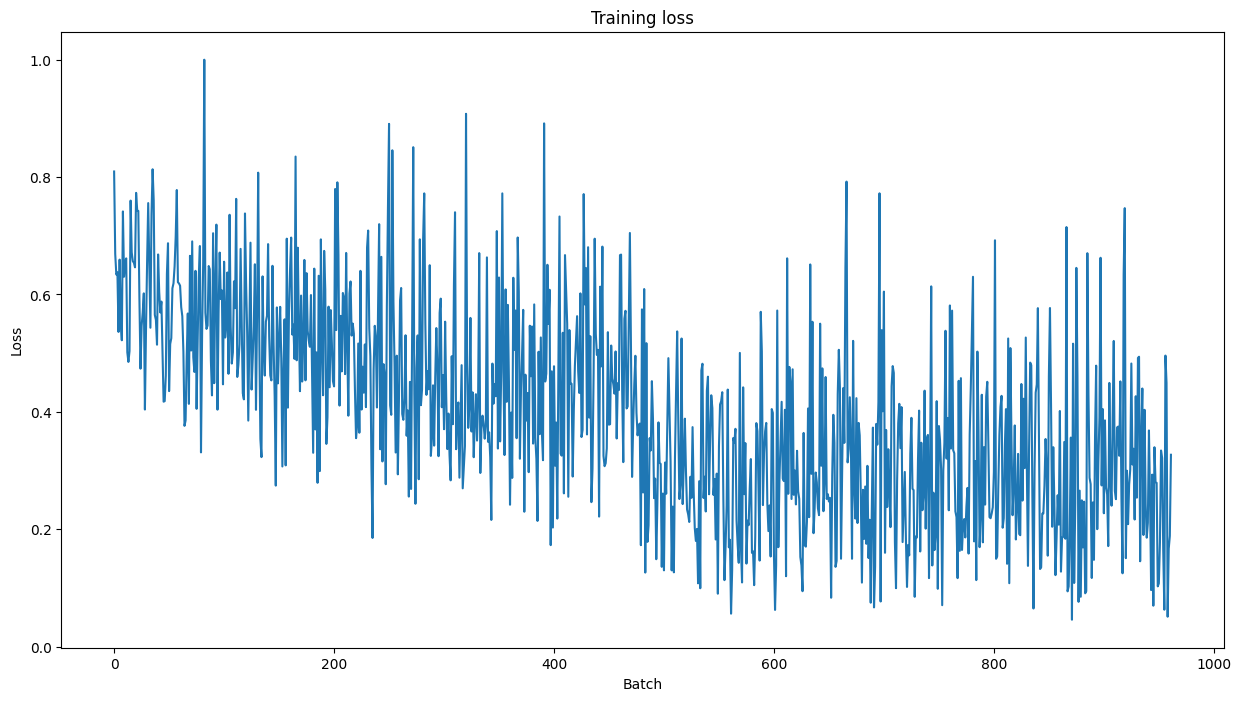

In [ ]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
torch.save(model.state_dict(), 'bert_sequence_classification_model.pth')

In [ ]:
# mount it
from google.colab import drive
drive.mount('/content/drive')
# copy it there
!cp bert_sequence_classification_model.pth /content/drive/MyDrive


Mounted at /content/drive


Let's Predict on the Held-out Set!

In [ ]:
df = pd.read_csv("/content/drive/My Drive/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

Same data preparations applied to the held-out data

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

# Assuming `df` and `tokenizer` are already defined and initialized

# Create sentence and label lists
sentences = df.sentence.values

# Add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

# Tokenize sentences
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

MAX_LEN = 128

# Convert tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Pad input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = [[float(i > 0) for i in seq] for seq in input_ids]

# Convert to tensors
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Batch size
batch_size = 32

# Create DataLoader
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to device
model.to(device)
print('done')

done


Predict on the test set

In [ ]:
# Put model in evaluation mode
model.eval()

# Tracking variables
predictions, true_labels = [], []

# Predict
for batch in prediction_dataloader:
    # Move batch to device
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from the dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Flatten the predictions and true labels lists of arrays into single arrays
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

# Convert logits to predicted labels by taking the argmax
predicted_labels = np.argmax(flat_predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(flat_true_labels, predicted_labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8062015503875969


Let's evaluate predictions using **Matthew's correlation coefficient** because this is the metric used by the wider NLP community to evaluate performance on CoLA.

With this metric, +1 is the best score, and -1 is the worst score.

Compare the performance against the state of the art models for this specific task.

In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Calculate MCC for each batch
for i in range(len(true_labels)):
    mcc = matthews_corrcoef(true_labels[i], np.argmax(predictions[i], axis=1).flatten())
    matthews_set.append(mcc)

# Print MCC values for each batch
for i, mcc in enumerate(matthews_set):
    print(f"Batch {i+1} MCC: {mcc}")


Batch 1 MCC: -0.14856415213808927
Batch 2 MCC: -0.17407765595569785
Batch 3 MCC: 0.4857959309463206
Batch 4 MCC: -0.02627034687463669
Batch 5 MCC: 0.32328707534629597
Batch 6 MCC: 0.8050112948805689
Batch 7 MCC: 0.4879500364742666
Batch 8 MCC: 0.0
Batch 9 MCC: 0.8333333333333334
Batch 10 MCC: 0.7530836820370708
Batch 11 MCC: 0.8459051693633014
Batch 12 MCC: 0.7624437362098716
Batch 13 MCC: 0.8150678894028793
Batch 14 MCC: 0.7141684885491869
Batch 15 MCC: 0.41179801403140964
Batch 16 MCC: 0.5844155844155844
Batch 17 MCC: 0.0


In [ ]:
# Flatten the predictions and true labels lists of arrays into single arrays
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)

# Convert logits to predicted labels by taking the argmax
predicted_labels = np.argmax(flat_predictions, axis=1)

# Calculate overall MCC
overall_mcc = matthews_corrcoef(flat_true_labels, predicted_labels)
print(f"Overall MCC: {overall_mcc}")

Overall MCC: 0.5244573852519377


In [ ]:
# Compare the overall MCC to state-of-the-art models on CoLA benchmark
state_of_the_art_mcc = {
    "BERT Large": 0.60,
    "RoBERTa Large": 0.63,
    "ALBERT": 0.63,
    "DeBERTa": 0.65
}

print("State-of-the-Art MCC Scores on CoLA Benchmark:")
for model, mcc in state_of_the_art_mcc.items():
    print(f"{model}: {mcc}")



State-of-the-Art MCC Scores on CoLA Benchmark:
BERT Large: 0.6
RoBERTa Large: 0.63
ALBERT: 0.63
DeBERTa: 0.65
